In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch" # alternatively you can use jax or tensorflow as the backend (see installation instructions in keras documentation)
import keras

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # helpful for splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler, MinMaxScaler # helpful for scaling data to be between 0 and 1 or have a mean of 0 and standard deviation of 1


In [3]:
file_path = '/Users/ctychen/Desktop/N3AS/spectrum_data/'
#reloading data
parameters = np.concatenate([np.load(file_path + "atm_retr_params_12800_"+str(i)+".npy") for i in range(12)])
spectra_set = np.concatenate([np.load(file_path + "atm_retr_data_12800_"+str(i)+".npy") for i in range(12)])

#take the log of the spectra - seems like this helped a lot with feature identification
spectra_set = np.log(spectra_set)

parameters = parameters[~np.isnan(spectra_set).any(axis=1)]
spectra_set = spectra_set[~np.isnan(spectra_set).any(axis=1)]

print(parameters.shape)
print(spectra_set.shape)

n_samples = parameters.shape[0]
n_features = 947

max_log_flux = np.max(spectra_set, axis=1)
min_log_flux = np.min(spectra_set, axis=1)
spectra_set = (spectra_set - min_log_flux[:, np.newaxis])/(max_log_flux - min_log_flux)[:, np.newaxis]

(153590, 16)
(153590, 947)


## Moving average on the spectra

In [4]:
def moving_average(x, n=3):
    return np.convolve(x, np.ones(n), 'valid') / n

In [5]:
averaged_spectra_set = np.array([moving_average(spectra_set[i], n=3) for i in range(n_samples)])

## Comparing () - Abs- Diff 
Trying and comparing max-abs-diff, mean-abs-diff, median-abs-diff... and let's see how they do at finding spectra with weirdness

In [6]:
#everything below is still using the same log(flux) spectrum (note, this is NOT the averaged spectra set.)

#max-abs-diff, for the original spectra set
spectra_max_absolute_differences = np.max(np.abs(np.diff(spectra_set, axis=1)), axis=1)    

#let's see how well finding the mean absolute difference works... 
spectra_mean_absolute_differences = np.mean(np.abs(np.diff(spectra_set, axis=1)), axis=1)

spectra_median_absolute_differences = np.median(np.abs(np.diff(spectra_set, axis=1)), axis=1)

spectra_max_absolute_differences.shape, spectra_mean_absolute_differences.shape, spectra_median_absolute_differences.shape

((153590,), (153590,), (153590,))

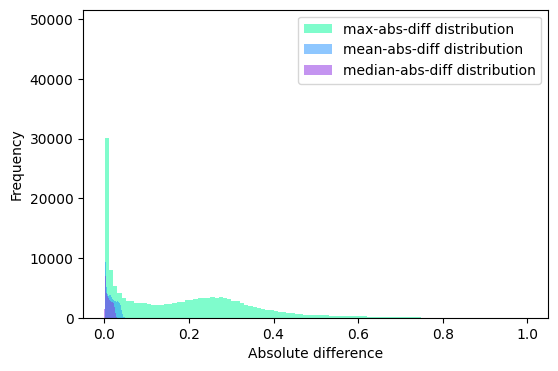

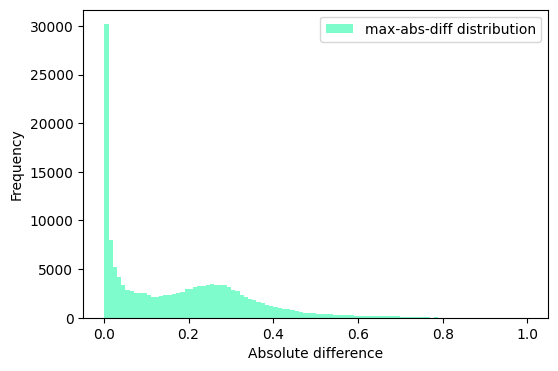

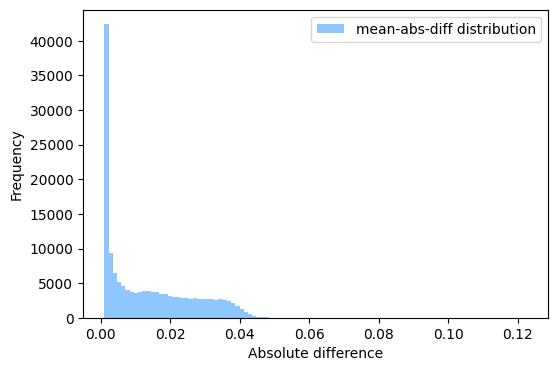

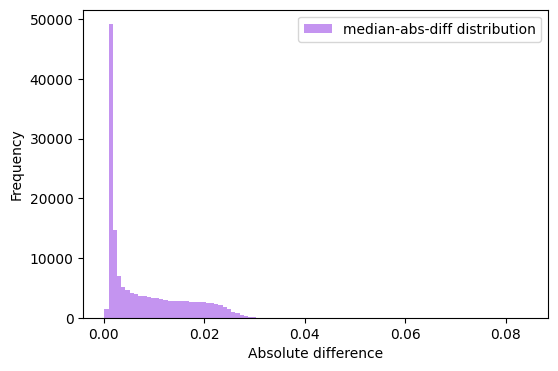

In [11]:
#what do the distributions of the max-abs-diff, mean-abs-diff, and median-abs-diff look like? 

plt.figure(figsize=(6, 4))
plt.hist(spectra_max_absolute_differences, bins=100, alpha=0.5, color='mediumspringgreen', label='max-abs-diff distribution')
plt.hist(spectra_mean_absolute_differences, bins=100, alpha=0.5, color='dodgerblue', label='mean-abs-diff distribution')
plt.hist(spectra_median_absolute_differences, bins=100, alpha=0.5, color='blueviolet', label='median-abs-diff distribution')
plt.xlabel('Absolute difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(spectra_max_absolute_differences, bins=100, alpha=0.5, color='mediumspringgreen', label='max-abs-diff distribution')
plt.xlabel('Absolute difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(spectra_mean_absolute_differences, bins=100, alpha=0.5, color='dodgerblue', label='mean-abs-diff distribution')
plt.xlabel('Absolute difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(spectra_median_absolute_differences, bins=100, alpha=0.5, color='blueviolet', label='median-abs-diff distribution')
plt.xlabel('Absolute difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [12]:
wavelengths = wavelengths = np.linspace(0.95, 2.45, n_features)

[149497  13323 149911  26413  79335  72684 140866 150574  46856 110332
  81226  70736  29913 139177   5113  17246 117791  27550  71947  15376]


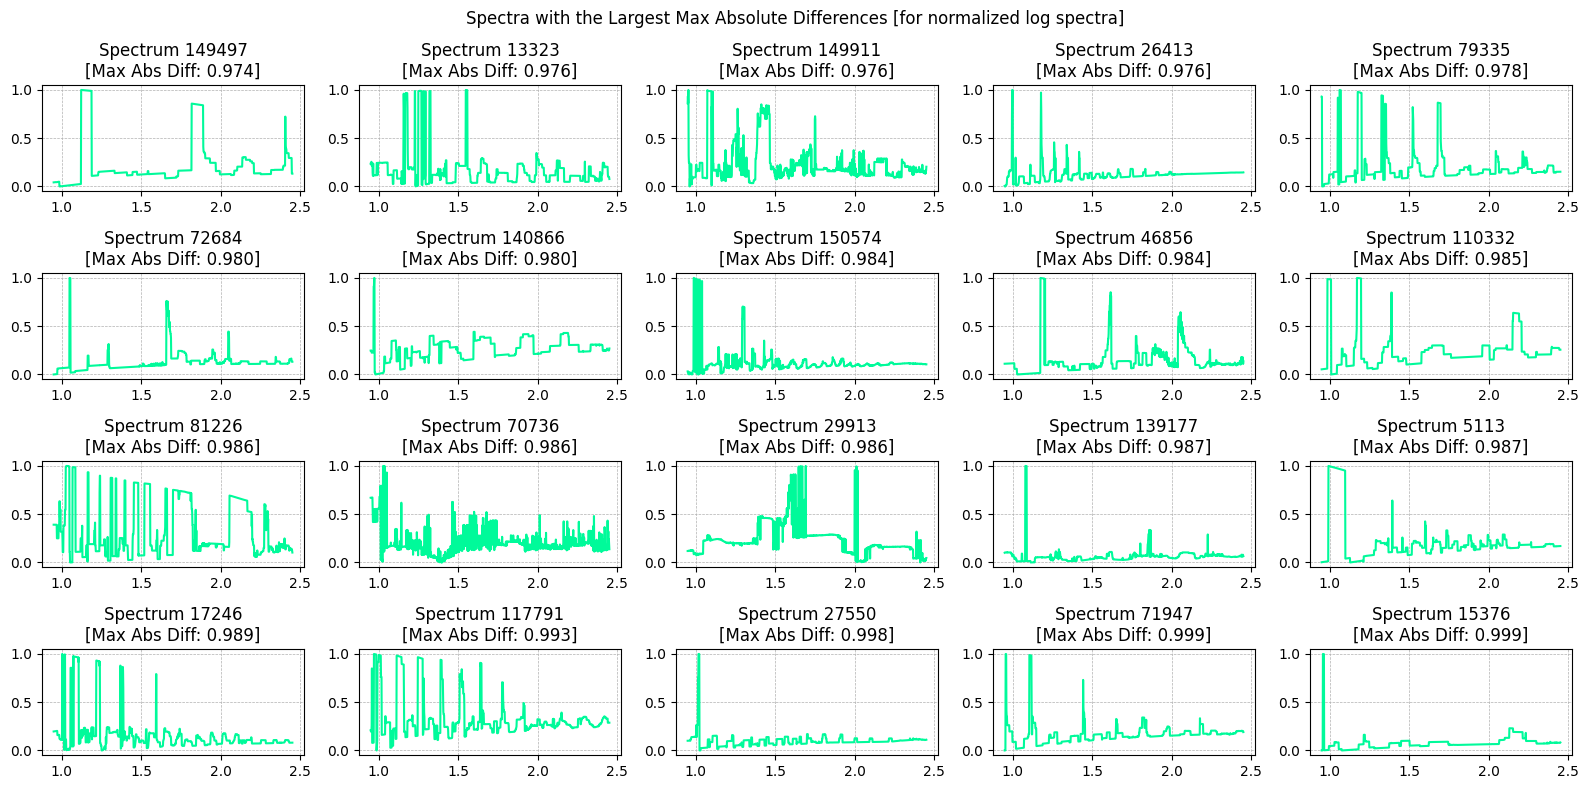

In [45]:
#what do the spectra with the largest max absolute differences look like?
max_abs_diff_indices = np.argsort(spectra_max_absolute_differences)[-20:]
print(max_abs_diff_indices)

indices = max_abs_diff_indices[-20:]

fig, axs = plt.subplots(4, 5, figsize=(16, 8))
axs = axs.flatten()
fig.suptitle('Spectra with the Largest Max Absolute Differences [for normalized log spectra]')
for i, index in enumerate(indices):
    spectrum = spectra_set[index]
    axs[i].plot(wavelengths, spectrum, color='mediumspringgreen')
    axs[i].set_title('Spectrum ' + str(index) + f'\n[Max Abs Diff: {spectra_max_absolute_differences[index]:.3f}]')
    axs[i].grid(linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

[ 52050  54668  94491  25481  46855 104201 138210  73192  36284 100456
 114272  12881  75742 114675  30912  41578   9301  96170 139362 105638]


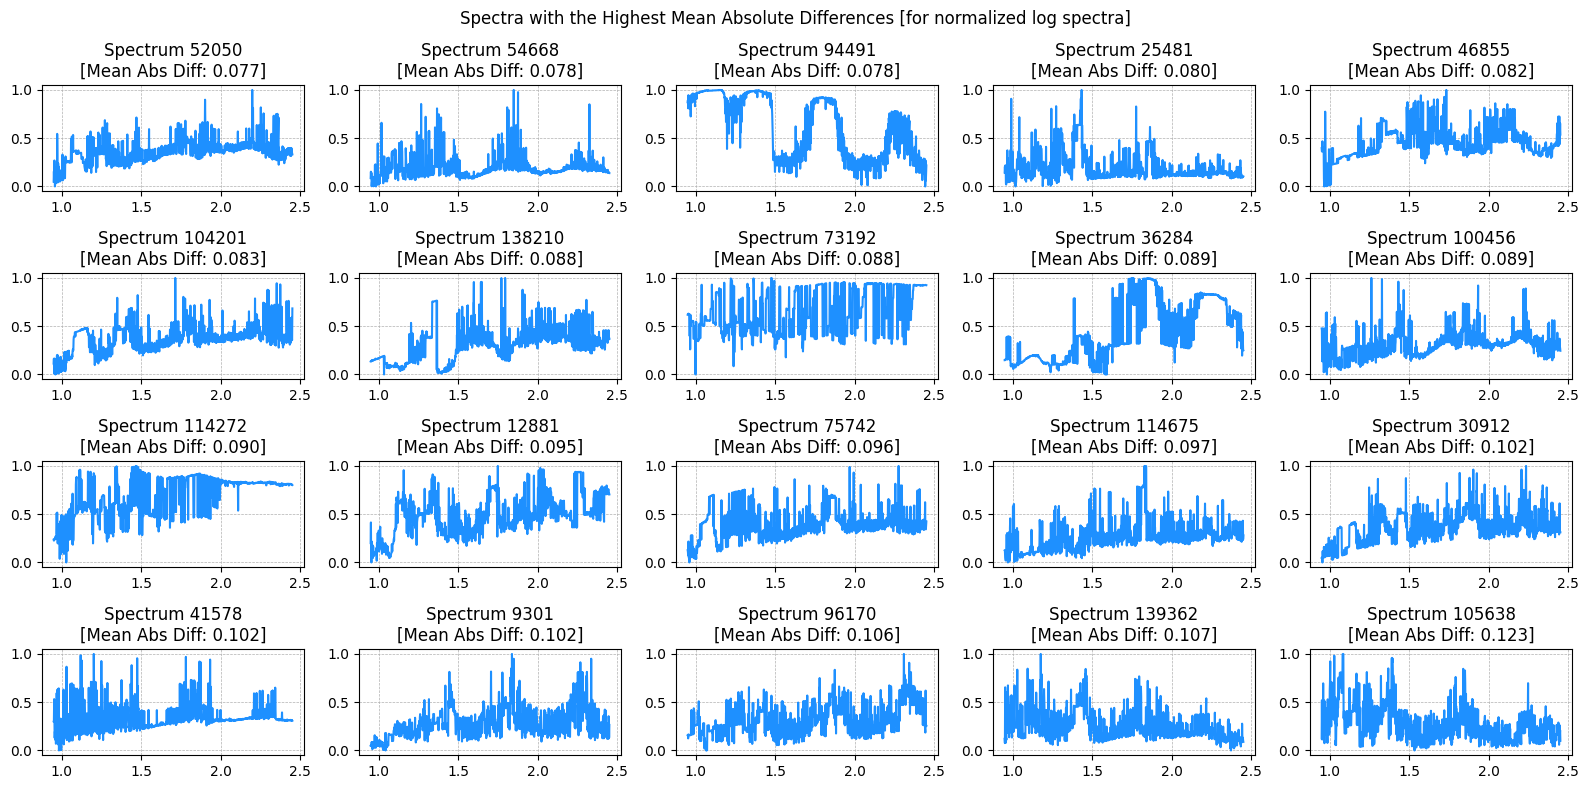

In [46]:
#what do the spectra with the highest mean absolute differences look like?
mean_abs_diff_indices = np.argsort(spectra_mean_absolute_differences)[-20:]
print(mean_abs_diff_indices)

indices = mean_abs_diff_indices[-20:]

fig, axs = plt.subplots(4, 5, figsize=(16, 8))
axs = axs.flatten()
fig.suptitle('Spectra with the Highest Mean Absolute Differences [for normalized log spectra]')
for i, index in enumerate(indices):
    spectrum = spectra_set[index]
    axs[i].plot(wavelengths, spectrum, color='dodgerblue')
    axs[i].set_title('Spectrum ' + str(index) + f'\n[Mean Abs Diff: {spectra_mean_absolute_differences[index]:.3f}]')
    axs[i].grid(linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

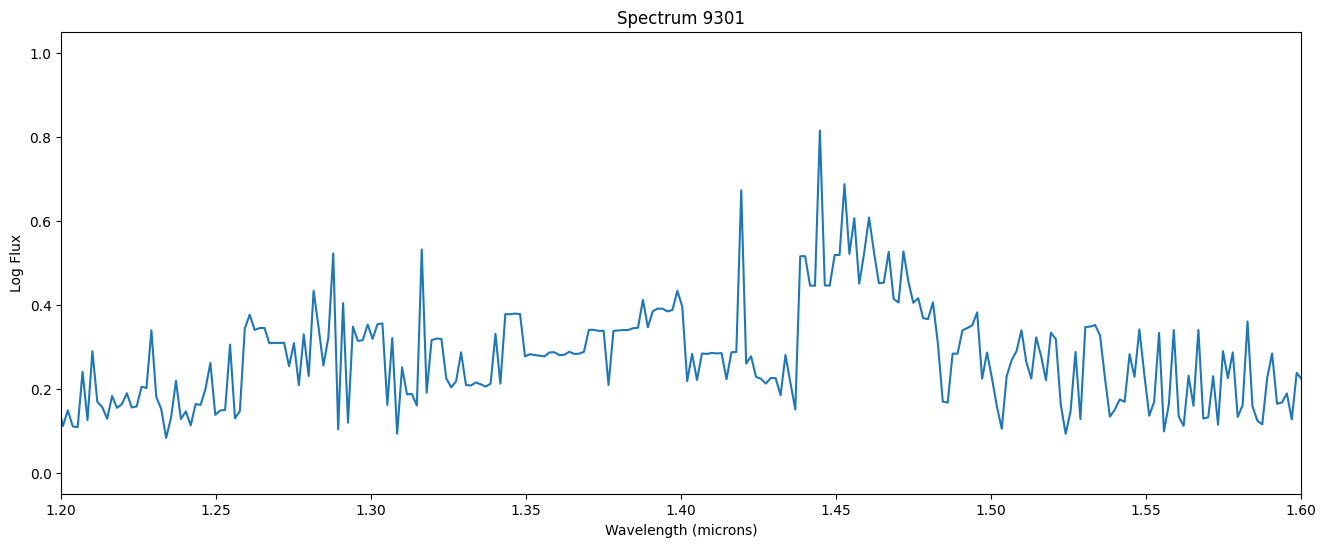

In [42]:
spec_test_idx = 9301 #94491 #105638 #139362
spectrum_test = spectra_set[spec_test_idx]
plt.figure(figsize=(16, 6))
plt.plot(wavelengths, spectrum_test)
# plt.yscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Log Flux')
plt.title('Spectrum ' + str(spec_test_idx))
plt.xlim(1.2, 1.6)
plt.show()

[ 54668  35557 138210 145527  83248  46224  25481 131216 100456  94491
 104201  52050  12881 114675  75742   9301  30912 139362  96170 105638]


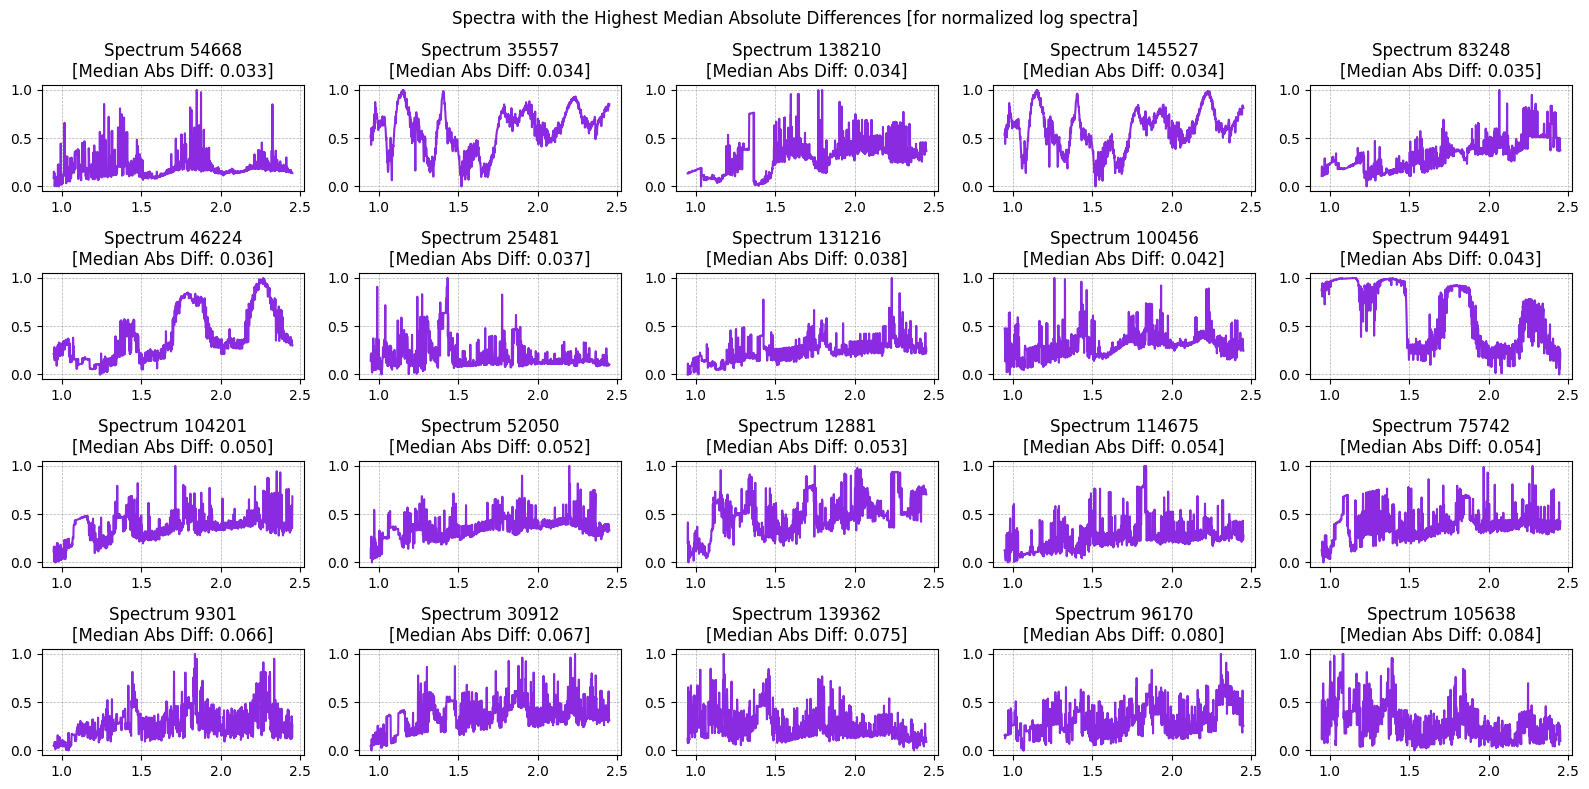

In [43]:
#what do the spectra with the highest median absolute differences look like?
median_abs_diff_indices = np.argsort(spectra_median_absolute_differences)[-20:]
print(median_abs_diff_indices)

indices = median_abs_diff_indices[-20:]

fig, axs = plt.subplots(4, 5, figsize=(16, 8))
axs = axs.flatten()
fig.suptitle('Spectra with the Highest Median Absolute Differences [for normalized log spectra]')
for i, index in enumerate(indices):
    spectrum = spectra_set[index]
    axs[i].plot(wavelengths, spectrum, color='blueviolet')
    axs[i].set_title('Spectrum ' + str(index) + f'\n[Median Abs Diff: {spectra_median_absolute_differences[index]:.3f}]')
    axs[i].grid(linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

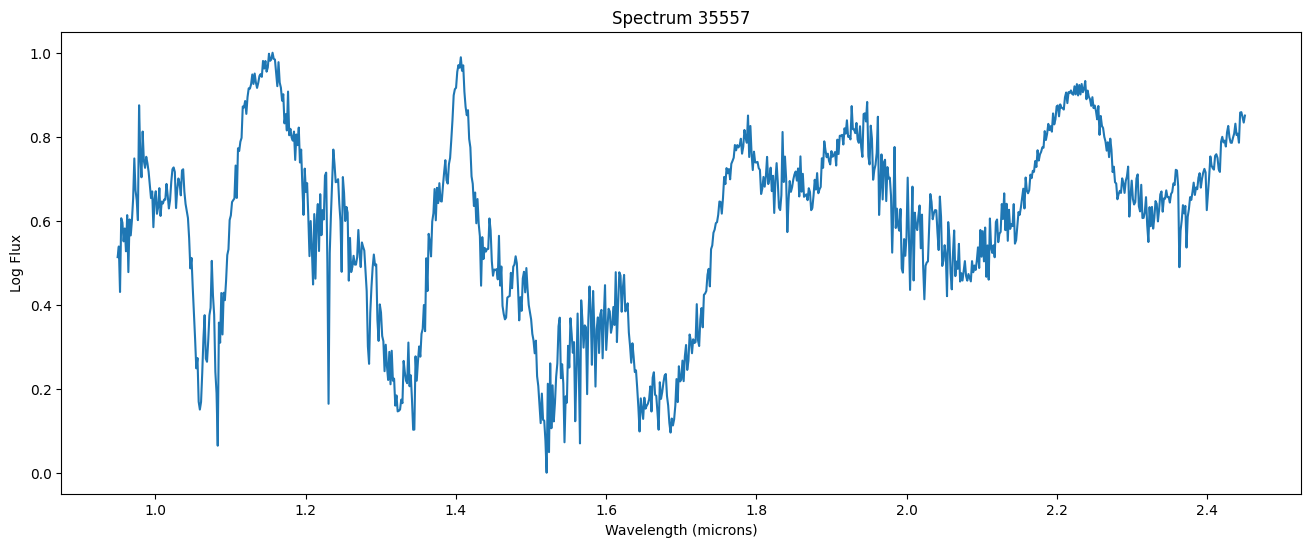

In [44]:
spec_test_idx = 35557
spectrum_test = spectra_set[spec_test_idx]
plt.figure(figsize=(16, 6))
plt.plot(wavelengths, spectrum_test)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Log Flux')
plt.title('Spectrum ' + str(spec_test_idx))
plt.show()